## Marketing_Email_Campaign
### Goal
Optimizing marketing campaigns is one of the most common data science tasks. Among the many possible marketing tools, one of the most efficient is using emails.

Emails are great cause they are free and can be easily personalized. Email optimization involves personalizing the text and/or the subject, who should receive it, when should be sent, etc. Machine Learning excels at this.

### Challenge Description
The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past.

They have chosen a random sample of users and emailed them. The email let the user know about a new feature implemented on the site. From the marketing team perspective, a success is if the user clicks on the link inside of the email. This link takes the user to the company site.

You are in charge of figuring out how the email campaign performed and were asked the following questions:
1. What percentage of users opened the email and what percentage clicked on the link within the email?
2. The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?
3. By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?
4. Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

### Data:
1.   "email_table" - info about each email that was sent
2.  "email_opened_table" -  the id of the emails that were opened at least once.
3. "link_clicked_table" -  the id of the emails whose link inside was clicked at least once. This user was then brought to the site.

## Data exploration

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
email_table = pd.read_csv('email_table.csv')
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [4]:
email_opened_table = pd.read_csv('email_opened_table.csv')
email_opened_table.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [5]:
link_clicked_table = pd.read_csv('link_clicked_table.csv')
link_clicked_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [6]:
# merge 
email_opened_table['opened'] = 1
link_clicked_table['clicked'] = 1
data = pd.merge(email_table,email_opened_table, how='left', on='email_id')
data = pd.merge(data,link_clicked_table, how = 'left', on='email_id')
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN


In [7]:
data.isnull().sum()

email_id                   0
email_text                 0
email_version              0
hour                       0
weekday                    0
user_country               0
user_past_purchases        0
opened                 89655
clicked                97881
dtype: int64

In [8]:
data = data.fillna(value=0)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


In [9]:
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)

In [10]:
print('{0:25s} {1:>8.4f}%'.format('Opened user percentage:', data['opened'].mean() * 100))
print('{0:25s} {1:>8.4f}%'.format('Clicked user percentage:', data['clicked'].mean() * 100))

Opened user percentage:    10.3450%
Clicked user percentage:    2.1190%


In [12]:
# GROUP BY length 
data_length = data[['email_text','clicked']].groupby('email_text').mean().sort_values(by='clicked',ascending=False).reset_index()
data_length

,email_text,clicked
0,short_email,0.023872
1,long_email,0.018538


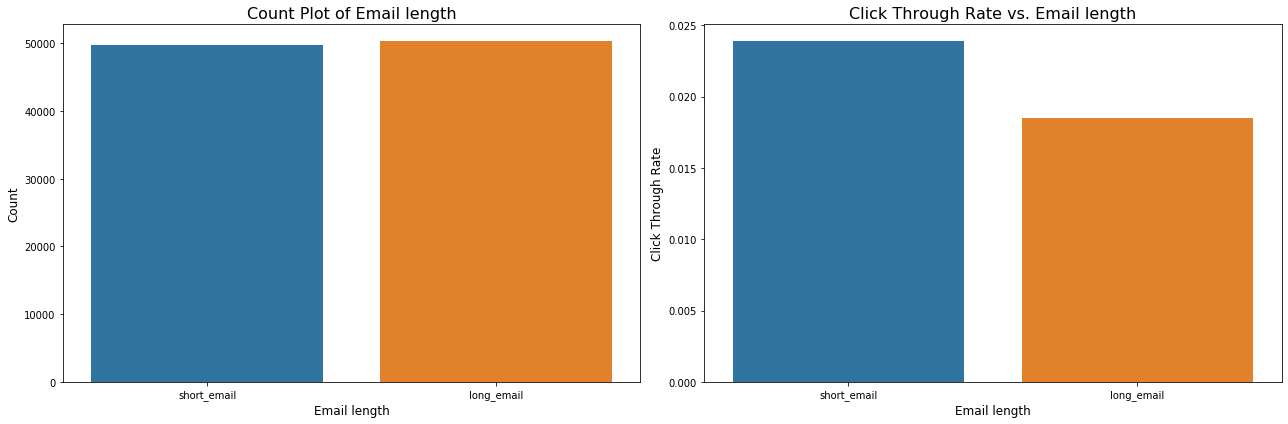

In [13]:
# visualize
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email length', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email length', fontsize=16)

sns.barplot(x='email_text', y='clicked', data=data_length, ax=ax[1])
ax[1].set_xlabel('Email length', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email length', fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
# GROUP BY version
data_version = data[['email_version','clicked']].groupby('email_version').mean().sort_values(by='clicked',ascending=False).reset_index()
data_version

,email_version,clicked
0,personalized,0.027294
1,generic,0.015137


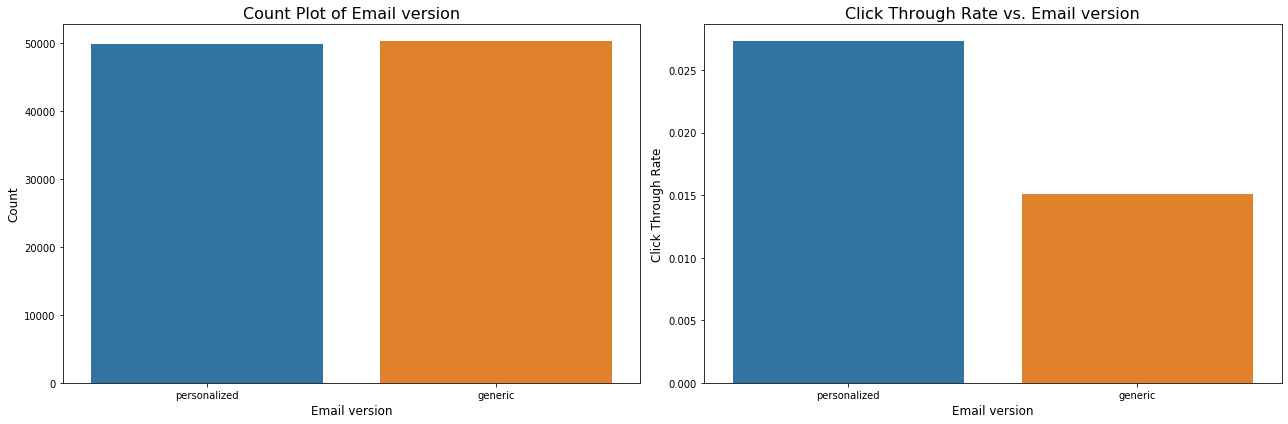

In [15]:
# visualize
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data_version, ax=ax[1])
ax[1].set_xlabel('Email version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email version', fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
# GROUP BY hour
data_hour = data[['hour','clicked']].groupby('hour').mean().sort_values(by='clicked',ascending=False).reset_index()
data_hour

,hour,clicked
0,23,0.041379
1,24,0.028986
2,10,0.028240
3,11,0.027128
4,9,0.025794
5,12,0.025661
6,15,0.024907
7,16,0.023197
8,14,0.020742
9,13,0.019889


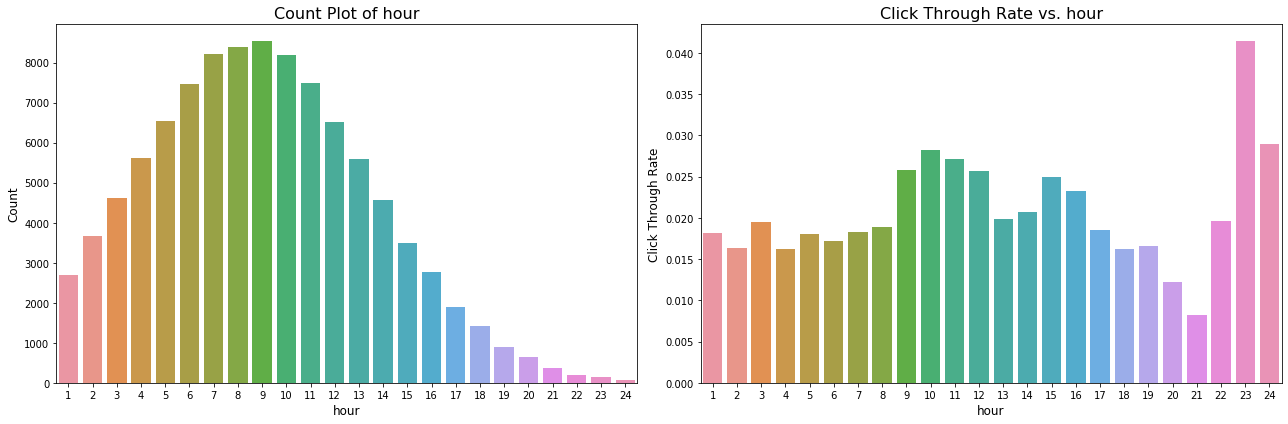

In [17]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data_hour, ax=ax[1])
ax[1].set_xlabel('hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. hour', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# GROUP BY weekday
data_weekday = data[['weekday','clicked']].groupby('weekday').mean().sort_values(by='clicked',ascending=False).reset_index()
data_weekday

,weekday,clicked
0,Wednesday,0.027620
1,Tuesday,0.024889
2,Thursday,0.024445
3,Monday,0.022906
4,Saturday,0.017846
5,Sunday,0.016751
6,Friday,0.014037


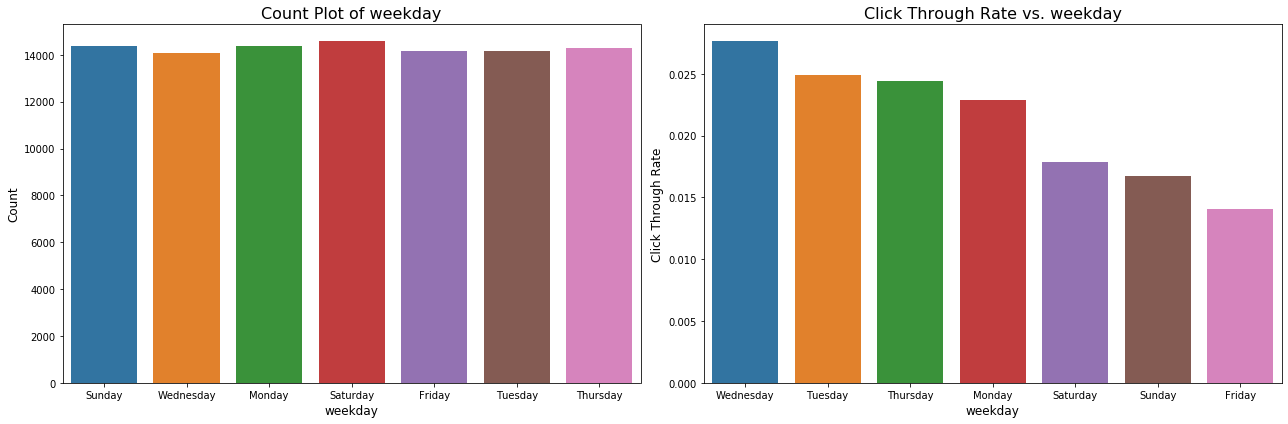

In [19]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data_weekday, ax=ax[1])
ax[1].set_xlabel('weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. weekday', fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
# GROUP BY user_country
data_country = data[['user_country','clicked']].groupby('user_country').mean().sort_values(by='clicked',ascending=False).reset_index()
data_country

,user_country,clicked
0,UK,0.024675
1,US,0.024360
2,ES,0.008327
3,FR,0.008004


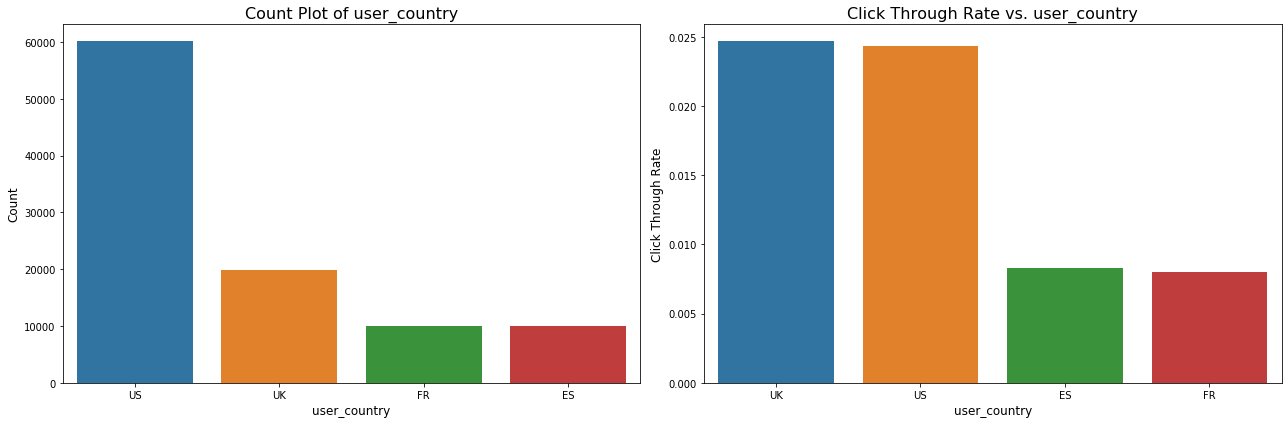

In [21]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('user_country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of user_country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data_country, ax=ax[1])
ax[1].set_xlabel('user_country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. user_country', fontsize=16)
plt.tight_layout()
plt.show()

In [22]:
# GROUP BY user_past_purchases
data_purchases = data[['user_past_purchases','clicked']].groupby('user_past_purchases').mean().sort_values(by='clicked',ascending=False).reset_index()
data_purchases

,user_past_purchases,clicked
0,22,1.000000
1,21,0.500000
2,19,0.200000
3,16,0.117647
4,15,0.117021
5,14,0.091160
6,17,0.083333
7,13,0.065744
8,12,0.065678
9,11,0.056021


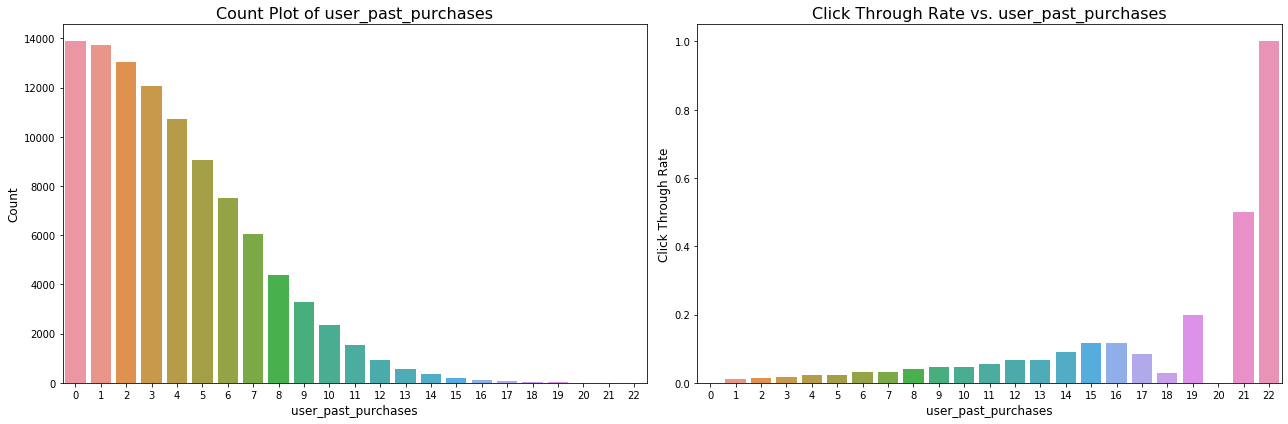

In [23]:
# Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('user_past_purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of user_past_purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data_purchases, ax=ax[1])
ax[1].set_xlabel('user_past_purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. user_past_purchases', fontsize=16)
plt.tight_layout()
plt.show()

## Random forest

In [24]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,9 days 21 hours 41 mins
H2O_cluster_timezone:,Europe/Amsterdam
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_opheliaming_6m9bgt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.372 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [25]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['clicked'] = h2o_df['clicked'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
# Split into 80% training and 20% test dataset
train, test = h2o_df.split_frame(ratios = [0.8], seed = 1234)
feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [28]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


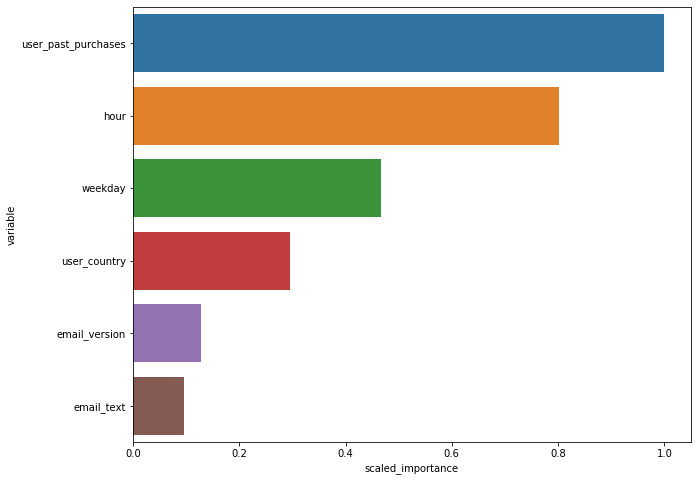

In [30]:
# Feature importance with color
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [31]:
# model performance 
perf = model.model_performance(test)
perf


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.02031936247143211
RMSE: 0.14254600124672775
LogLoss: 0.1092956350661164
Mean Per-Class Error: 0.3546285790977337
AUC: 0.6805946760746459
AUCPR: 0.03594945666421317
Gini: 0.3611893521492917

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0075226521219392915: 


,,0,1,Error,Rate
0,0,15066.0,4561.0,0.2324,(4561.0/19627.0)
1,1,228.0,182.0,0.5561,(228.0/410.0)
2,Total,15294.0,4743.0,0.239,(4789.0/20037.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.007523,0.070638,304.0
1,max f2,0.005390,0.142622,329.0
2,max f0point5,0.088366,0.061807,99.0
3,max accuracy,0.259038,0.979488,0.0
4,max precision,0.144486,0.084507,30.0
5,max recall,0.000350,1.000000,397.0
6,max specificity,0.259038,0.999949,0.0
7,max absolute_mcc,0.004133,0.082383,345.0
8,max min_per_class_accuracy,0.005390,0.632394,329.0
9,max mean_per_class_accuracy,0.004133,0.645371,345.0



Gains/Lift Table: Avg response rate:  2.05 %, avg score:  1.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010031,0.114079,2.917656,2.917656,0.059701,0.141051,0.059701,0.141051,0.029268,0.029268,191.765562,191.765562,0.019639
1,2,0.020013,0.093927,2.443537,2.681187,0.050000,0.103691,0.054863,0.122417,0.024390,0.053659,144.353659,168.118728,0.034348
2,3,0.030194,0.080037,2.156062,2.504120,0.044118,0.086601,0.051240,0.110341,0.021951,0.075610,115.606169,150.412014,0.046364
3,4,0.040026,0.070643,2.232673,2.437443,0.045685,0.074938,0.049875,0.101644,0.021951,0.097561,123.267302,143.744298,0.058737
4,5,0.050007,0.062758,1.221768,2.194793,0.025000,0.066411,0.044910,0.094612,0.012195,0.109756,22.176829,119.479334,0.060997
5,6,0.100265,0.035488,1.019151,1.605509,0.020854,0.048983,0.032852,0.071740,0.051220,0.160976,1.915131,60.550935,0.061979
6,7,0.150022,0.011280,1.813658,1.674546,0.037111,0.021546,0.034265,0.055092,0.090244,0.251220,81.365805,67.454603,0.103311
7,8,0.200030,0.008451,2.341113,1.841188,0.047904,0.009550,0.037675,0.043707,0.117073,0.368293,134.111290,84.118775,0.171778
8,9,0.299995,0.006336,1.561521,1.747997,0.031952,0.007280,0.035768,0.031569,0.156098,0.524390,56.152113,74.799656,0.229083
9,10,0.400010,0.005042,1.414422,1.664593,0.028942,0.005665,0.034061,0.025092,0.141463,0.665854,41.442237,66.459261,0.271397


In [32]:
perf.F1()

[[0.0075226521219392915, 0.07063846303124394]]

In [33]:
perf.accuracy()

[[0.2590384950037218, 0.9794879472974997]]

In [34]:
perf.auc()

0.6805946760746459

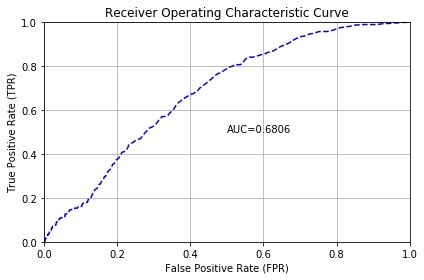

In [35]:
perf.plot(type = "roc")

In [36]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_ae1f closed.
